In [1]:
using InteractiveUtils
versioninfo()

Julia Version 1.4.2
Commit 44fa15b150* (2020-05-23 18:35 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-3210M CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, ivybridge)


In [2]:
using Plots
gr()

Plots.GRBackend()

In [3]:
module AstarPlanner

############################
###### initialization ######
############################

function init(ox_, oy_, reso_, rr_)
    global reso = reso_
    global rr = rr_
    calc_obstacle_map(ox_, oy_)
    get_motion_model()
end

function calc_obstacle_map(ox, oy)
    global minx = round(minimum(ox))
    global miny = round(minimum(oy))
    global maxx = round(maximum(ox))
    global maxy = round(maximum(oy))
    @show minx, miny, maxx, maxy

    global xwidth = round((maxx - minx) / reso)
    global ywidth = round((maxy - miny) / reso)
    @show xwidth, ywidth
    
    global obmap = [[false for i = 1:ywidth] for i = 1:xwidth]
    
    for ix in 1:xwidth
        x = calc_grid_position(ix, minx)
        for iy in 1:ywidth
            y = calc_grid_position(iy, miny)
            for (iox, ioy) in zip(ox, oy)
                d = sqrt((iox - x)^2 + (ioy - y)^2)
                if d <= rr
                    obmap[Int(ix)][Int(iy)] = true
                    break
                end
            end
        end
    end
end

function get_motion_model()
    # dx, dy, cost
    global motion = [[1, 0, 1],
              [0, 1, 1],
              [-1, 0, 1],
              [0, -1, 1],
              [-1, -1, sqrt(2)],
              [-1, 1, sqrt(2)],
              [1, -1, sqrt(2)],
              [1, 1, sqrt(2)]]
end

function calc_grid_position(index, minp)
    return index * reso + minp
end

######################
###### planning ######
######################

mutable struct Node
    x::Int
    y::Int
    cost
    pind
end

function planning(sx_, sy_, gx_, gy_)
    nstart = Node(calc_xyindex(sx_, minx), calc_xyindex(sy_, miny), 0.0, -1)
    ngoal = Node(calc_xyindex(gx_, minx), calc_xyindex(gy_, miny), 0.0, -1)
    
    open_set, closed_set = Dict(), Dict()
    open_set[calc_grid_index(nstart)] = nstart
    
    while true
        if length(open_set) == 0
            println("Open set is empty..")
            break
        end
        #c_id = min(open_set, key = o -> open_set[o].cost + calc_heuristic(ngoal, open_set[o]))
        min_cost = 999
        c_id = -1
        for key in keys(open_set)
            cost = open_set[key].cost + calc_heuristic(ngoal, open_set[key])
            if cost < min_cost
                min_cost = cost
                c_id = Int(key)
            end
        end
        
        current = open_set[c_id]
        
        if (current.x == ngoal.x) && (current.y == ngoal.y)
            println("Find goal")
            ngoal.pind = current.pind
            ngoal.cost = current.cost
            break
        end
        
        delete!(open_set, c_id)
        
        closed_set[c_id] = current
        
        for (i, _) in enumerate(motion)
            node = Node(current.x + motion[i][1], current.y + motion[i][2], current.cost + motion[i][3], c_id)
            n_id = calc_grid_index(node)
            
            if !verify_node(node)
                continue
            end
            
            if haskey(closed_set, n_id) # n_id in closed_set
                continue
            end
            
            if !haskey(open_set, n_id) # n_id not in open_set
                open_set[n_id] = node
            else
                if open_set[n_id].cost > node.cost
                    open_set[n_id] = node
                end
            end
        end
    end
    
    rx, ry = calc_final_path(ngoal, closed_set)
    
    return rx, ry
end

function calc_xyindex(position, min_pos)
    return round((position - min_pos) / reso)
end

function calc_grid_index(node)
    return Int((node.y - miny) * xwidth + (node.x - minx))
end

function calc_heuristic(n1, n2)
    w = 1.0
    d = w * sqrt((n1.x - n2.x)^2 + (n1.y - n2.y)^2)
    return d
end

function verify_node(node)
    px = calc_grid_position(node.x, minx)
    py = calc_grid_position(node.y, miny)
    
    if px <= miny
        return false
    elseif py <= miny
        return false
    elseif px >= maxx
        return false
    elseif py >= maxy
        return false
    end
    
    if obmap[node.x][node.y]
        return false
    end
    
    return true
end

function calc_final_path(ngoal, closedset)
    rx, ry = [calc_grid_position(ngoal.x, minx)], [calc_grid_position(ngoal.y, miny)]
    pind = ngoal.pind
    while pind != -1
        n = closedset[pind]
        append!(rx, calc_grid_position(n.x, minx))
        append!(ry, calc_grid_position(n.y, miny))
        pind = n.pind
    end
    
    return rx, ry
end
end

Main.AstarPlanner

In [4]:
sx = 10.0
sy = 10.0
gx = 50.0
gy = 50.0
grid_size = 2.0
robot_radius = 1.0

ox, oy = [], []

for i in -10:60    
    append!(ox,i)
    append!(oy,-10.0)
end

for i in -10:60    
    append!(ox,60.0)
    append!(oy,i)
end

for i in -10:60
    append!(ox,i)
    append!(oy,60.0)
end

for i in -10:60   
    append!(ox,-10.0)
    append!(oy,i)
end

for i in -10:40    
    append!(ox,20.0)
    append!(oy,i)
end

for i in 0:40    
    append!(ox,40.0)
    append!(oy,60.0 - i)
end

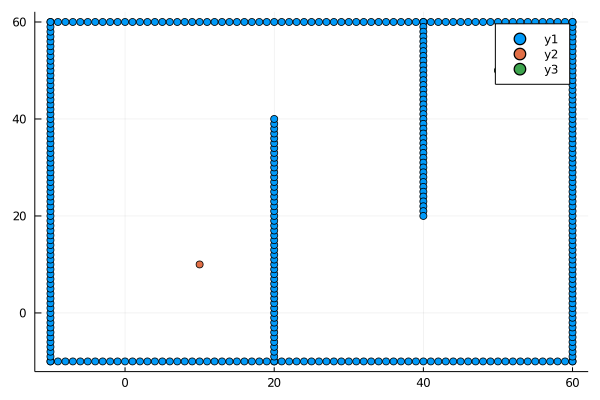

In [5]:
plot(ox, oy, seriestype = :scatter)
plot!([sx], [sy], seriestype = :scatter)
plot!([gx], [gy], seriestype = :scatter)

In [6]:
planner = AstarPlanner

Main.AstarPlanner

In [7]:
planner.init(ox, oy, grid_size, robot_radius);

(minx, miny, maxx, maxy) = (-10.0, -10.0, 60.0, 60.0)
(xwidth, ywidth) = (35.0, 35.0)


In [8]:
rx, ry = planner.planning(sx, sy, gx, gy);

Find goal


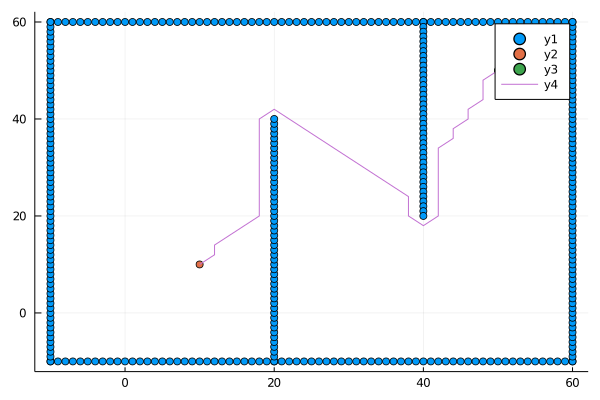

In [9]:
plot(ox, oy, seriestype = :scatter)
plot!([sx], [sy], seriestype = :scatter)
plot!([gx], [gy], seriestype = :scatter)
plot!(rx, ry)

In [10]:
planner.init(ox, oy, grid_size, robot_radius*5);

(minx, miny, maxx, maxy) = (-10.0, -10.0, 60.0, 60.0)
(xwidth, ywidth) = (35.0, 35.0)


In [11]:
rx, ry = planner.planning(sx, sy, gx, gy);

Find goal


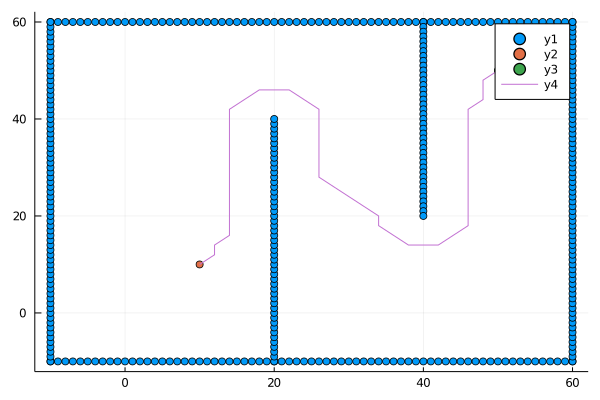

In [12]:
plot(ox, oy, seriestype = :scatter)
plot!([sx], [sy], seriestype = :scatter)
plot!([gx], [gy], seriestype = :scatter)
plot!(rx, ry)